#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
# Установим дополнительно необходимые библиотеки

In [2]:
!pip install --quiet optuna

In [3]:
import optuna
optuna.__version__

'3.1.0'

In [4]:
!pip install lightgbm

In [5]:
import lightgbm as lgb
lgb.__version__

'3.3.5'

In [6]:
!pip install xgboost

In [7]:
import xgboost
xgboost.__version__

'1.7.4'

In [8]:
!pip install -q scikit-learn==1.2.2

In [9]:
import sklearn
sklearn.__version__

'1.2.2'

In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)

from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

%matplotlib inline

RANDOM_STATE = 732568

## Подготовка

In [11]:
def read_csv(filepath):
    return pd.read_csv(filepath, index_col='datetime', parse_dates=['datetime'])

def load_dataset(dataset_name):
    return read_csv('/datasets/' + dataset_name)

In [12]:
data = load_dataset('taxi.csv')
display(data.head())
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [13]:
data = data.sort_index()
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [14]:
init_data = data.copy()

In [15]:
data = data.resample('1H').sum()

## Анализ

### Первичный анализ

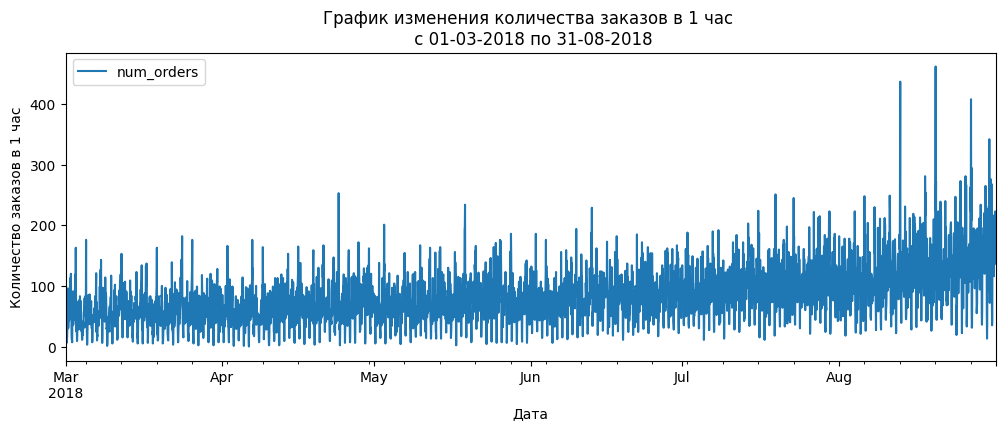

In [16]:
data.plot(figsize=(12, 4))
plt.ylabel('Количество заказов в 1 час')
plt.xlabel('Дата')

start = data.index[0].strftime('%d-%m-%Y')
end = data.index[-1].strftime('%d-%m-%Y')

plt.title(f'График изменения количества заказов в 1 час \n c {start} по {end}');

In [17]:
def datetime_filter(df: pd.core.frame.DataFrame,
                    start_date: str,
                    days_interval: int):
    
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = start_date + timedelta(days=days_interval)
    return (df.index > start_date) & (df.index <= end_date)

In [18]:
def display_interval(df: pd.core.frame.DataFrame,
                     start_date: str,
                     days_interval: int):
    
    date_range = datetime_filter(df, start_date, days_interval)
    df_to_display = df.loc[date_range]
    
    df_to_display.plot(figsize=(12, 4))
    
    plt.ylabel('Количество заказов в 1 час')
    plt.xlabel('Дата')

    start = df_to_display.index[0].strftime('%d-%m-%Y')
    end = df_to_display.index[-1].strftime('%d-%m-%Y')
    plt.title('График изменения количества заказов в 1 час '
              + f'\n зв {days_interval} дней c {start} по {end}');

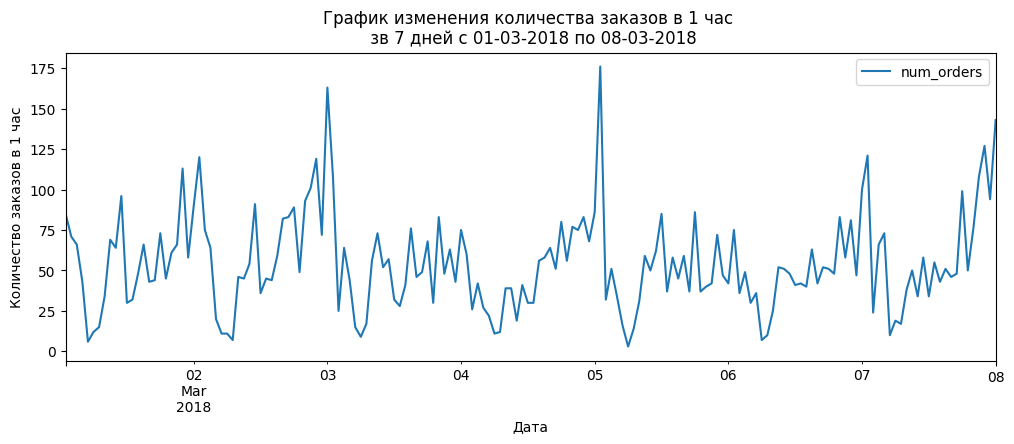

In [19]:
display_interval(data, '2018-03-1', 7)

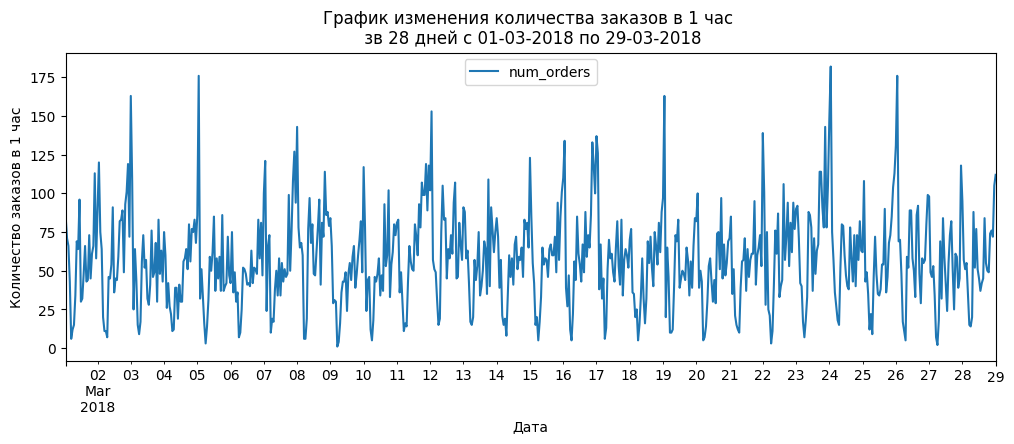

In [20]:
display_interval(data, '2018-03-1', 28)

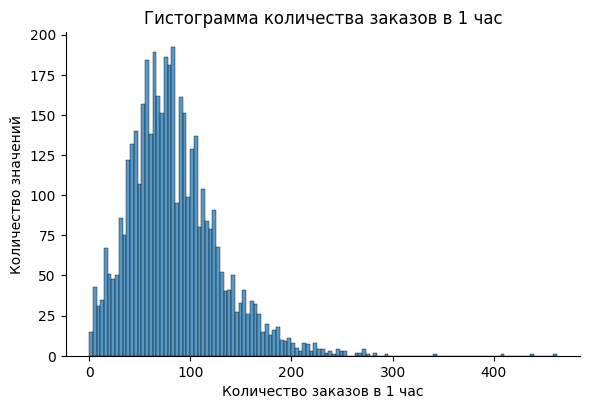

In [21]:
sns.displot(
    data.num_orders,
    bins=data.num_orders.nunique() // 2,
    height=4,
    aspect=1.5
)
plt.ylabel('Количество значений')
plt.xlabel('Количество заказов в 1 час')
plt.title('Гистограмма количества заказов в 1 час');

In [22]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [23]:
data.value_counts()

num_orders
73            65
57            58
66            58
78            54
84            52
              ..
232            1
238            1
239            1
240            1
462            1
Length: 251, dtype: int64

In [24]:
data.num_orders.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

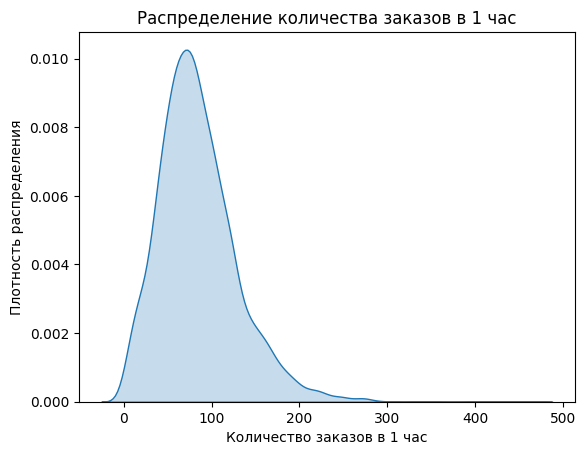

In [25]:
sns.kdeplot(
    data.num_orders,
    shade=True
)
plt.ylabel('Плотность распределения')
plt.xlabel('Количество заказов в 1 час')
plt.title('Распределение количества заказов в 1 час');

Из графиков видно, что целевая переменная имеет распределение Пуассона.

### Анализ сезонности

Сделаем декомпозицию ряда, посмотрим на три составляющие: тренд, сезонность и остаток

#### Тренд

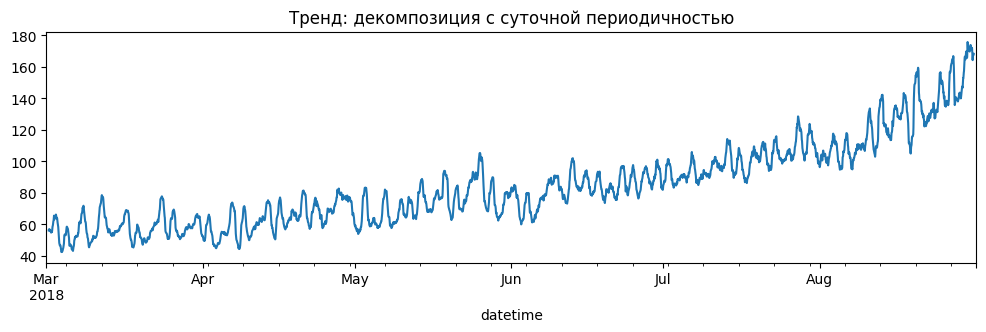

In [26]:
decomposed = seasonal_decompose(data.num_orders, period=24)
# period=24 соответствует периоду в 1 день - суточна периодичность

plt.figure(figsize=(12, 3))
decomposed.trend.plot()
plt.title('Тренд: декомпозиция с суточной периодичностью');

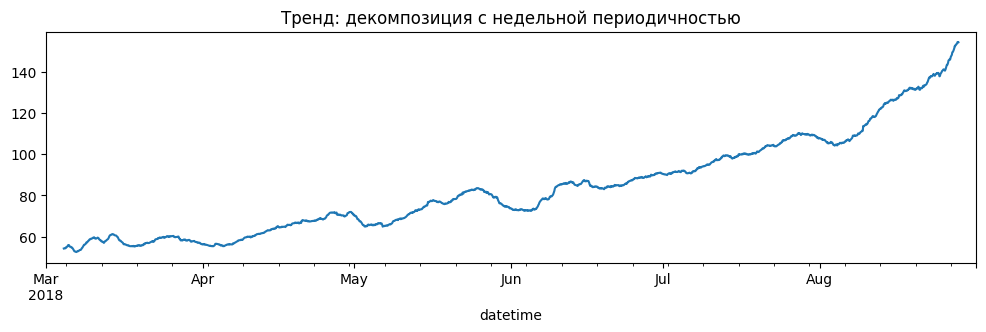

In [27]:
decomposed = seasonal_decompose(data.num_orders, period=168)
# period=168 соответствует периоду в 7 дней - недельная периодичность

plt.figure(figsize=(12, 3))
decomposed.trend.plot()
plt.title('Тренд: декомпозиция с недельной периодичностью');

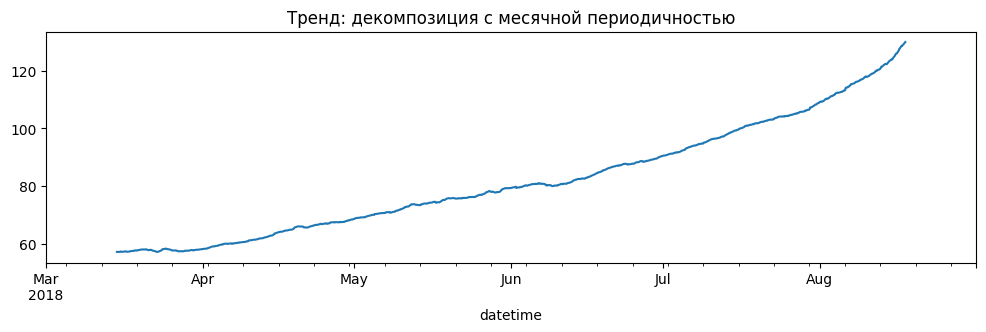

In [28]:
decomposed = seasonal_decompose(data.num_orders, period=672)
# period=672 соответствует периоду в 28 день - месячная периодичность

plt.figure(figsize=(12, 3))
decomposed.trend.plot()
plt.title('Тренд: декомпозиция с месячной периодичностью');

Из анализа графиков тренда с разной периодичностью (суточной, недельной, месячной) видно, что:
 - в апреле тренд в среднем не изменяется, или не наблюдается;
 - с начала апреля до начала августа наблюдается "относительно равномерное" увеличение заказов. Если анализировать график с недельной периодичностью, то в этот период увеличения наблюдаются локальные небольшие спады в конце апреля - начале мая, в конце мая - начале июня, в конце июля - начале августа, при этом спада в конце июня - начале июля не наблюдается;
 - в течение августа скорость увеличение заказов от начала месяца к концу увеличивается по сравнению с предыдущим периодом увеличения с апреля по август, при этом скорость неравномерная - к концу месяца наблюдается ускорение увеличения заказов. Можно предположить, что это связано с тем, что август является месяцем с максимальным количеством туристов (или отпусков).

#### Сезонность (периодичность)

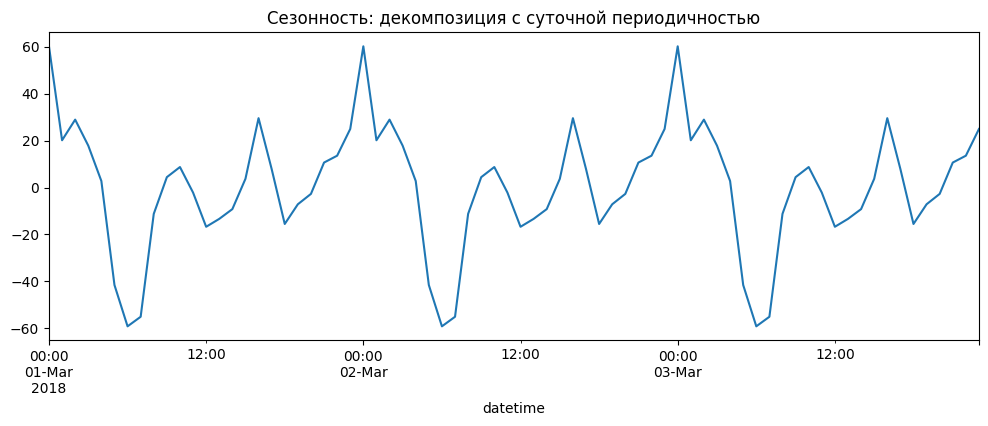

In [29]:
decomposed = seasonal_decompose(data.num_orders, period=24)
# period=24 соответствует периоду в 1 день - суточна периодичность

plt.figure(figsize=(12, 4))

start = '2018-03-1'
end = '2018-03-3'

decomposed.seasonal[start:end].plot()
plt.title('Сезонность: декомпозиция с суточной периодичностью');

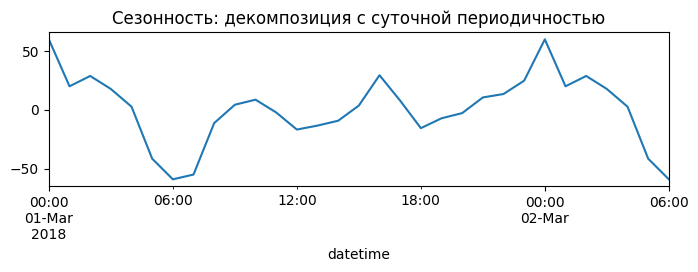

In [30]:
decomposed = seasonal_decompose(data.num_orders, period=24)
# period=24 соответствует периоду в 1 день - суточна периодичность

plt.figure(figsize=(8, 2))

start = '2018-03-1'
end = '2018-03-2 06'

decomposed.seasonal[start:end].plot()
plt.title('Сезонность: декомпозиция с суточной периодичностью');

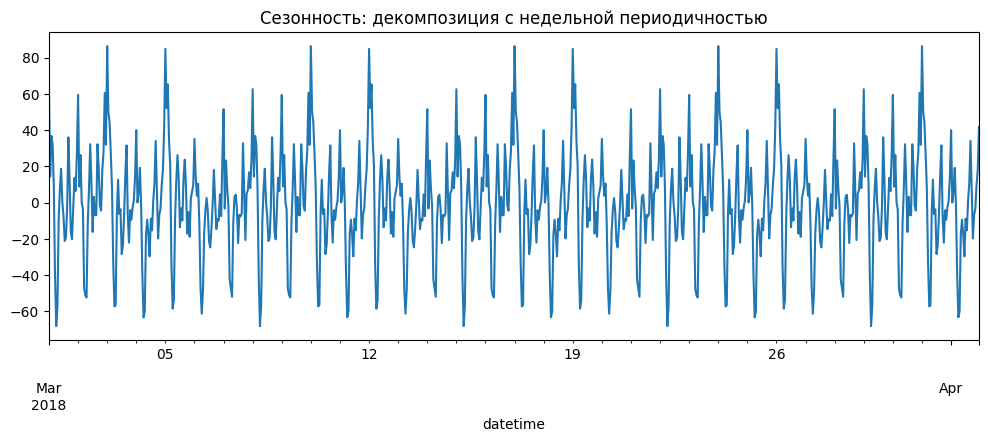

In [31]:
decomposed = seasonal_decompose(data.num_orders, period=168)
# period=168 соответствует периоду в 7 дней - недельная периодичность

plt.figure(figsize=(12, 4))

start = '2018-03-1'
end = '2018-04-01'

decomposed.seasonal[start:end].plot()
plt.title('Сезонность: декомпозиция с недельной периодичностью');

In [32]:
data.index[0]

Timestamp('2018-03-01 00:00:00', freq='H')

In [33]:
data.index[0].weekday()

3

1-ое марта 2018 года - это день недели с индексом `3`, что обозначает четверг

Из анализа графиков сезонности с разной периодичностью (суточная, недельная) видно, что:
 - наблюдается суточная периодичность:
    - с минимум в 6 утра;
    - с максимумом в 12 ночи;
    - с локальными максимумами в течение дня в 10 и 16 часов;
 - также наблюдается недельная периодичность:
    - с минимальным значением в 6 часов в четверг каждой недели;
    - с максимальными значениями в 12 часов ночи в ночь с пятницы на субботу и в ночь с воскресенья на понедельник.

#### Остатки

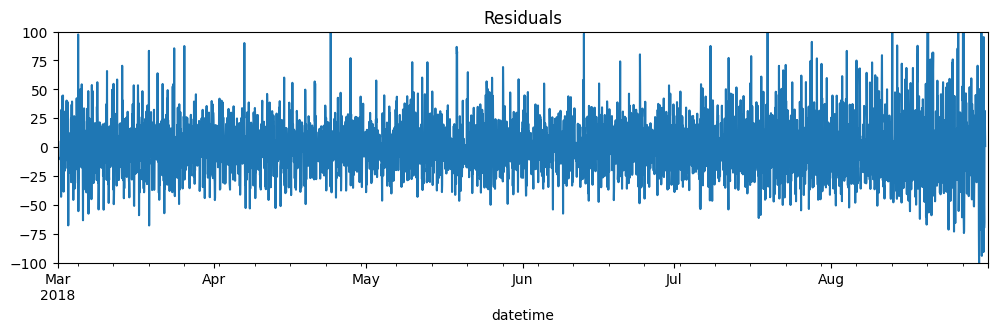

In [34]:
decomposed = seasonal_decompose(data.num_orders, period=24)

plt.figure(figsize=(12, 3))
plt.ylim(-100, 100)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals');

На графике остатков никаких характерных особенностей выделить нельзя.

### Усреднение по суткам, неделям

Посмотрим на изменение среднего значения заказов за 1 сутки и за 1 неделю.

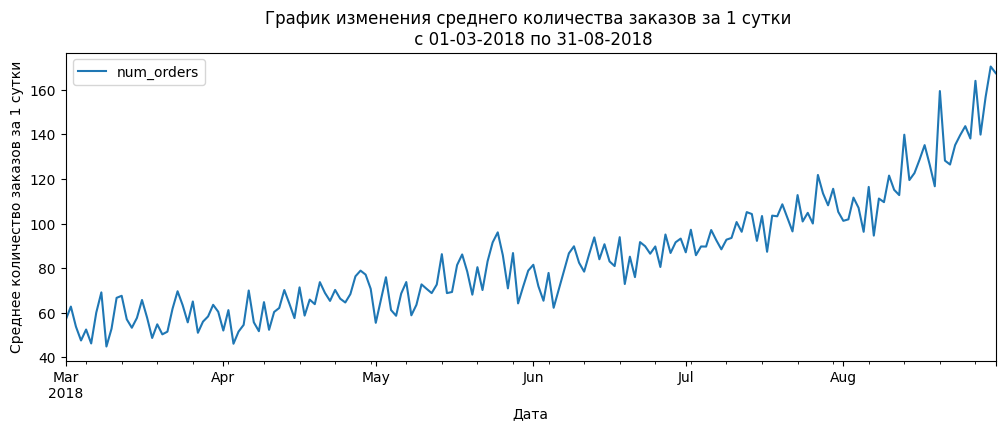

In [35]:
data.resample('1D').mean().plot(figsize=(12, 4))

plt.ylabel('Среднее количество заказов за 1 сутки')
plt.xlabel('Дата')

start = data.index[0].strftime('%d-%m-%Y')
end = data.index[-1].strftime('%d-%m-%Y')

plt.title(f'График изменения среднего количества заказов за 1 сутки \n c {start} по {end}');

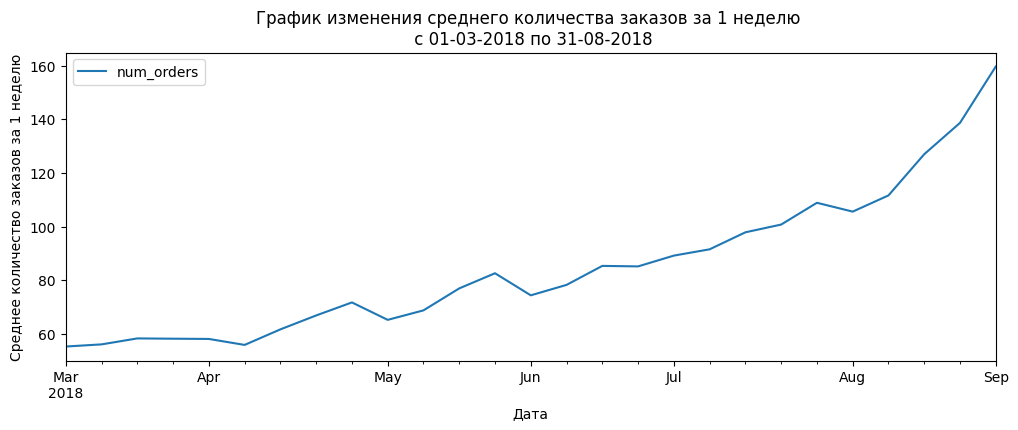

In [36]:
data.resample('1W').mean().plot(figsize=(12, 4))

plt.ylabel('Среднее количество заказов за 1 неделю')
plt.xlabel('Дата')

start = data.index[0].strftime('%d-%m-%Y')
end = data.index[-1].strftime('%d-%m-%Y')

plt.title(f'График изменения среднего количества заказов за 1 неделю \n c {start} по {end}');

Эти графики приближённо совпадают с графиками тренда при декомпозиции с суточной и недельной периодичностью

Теперь посмотрим на изменение при скользящем усреднении с окном в сутки и неделю.

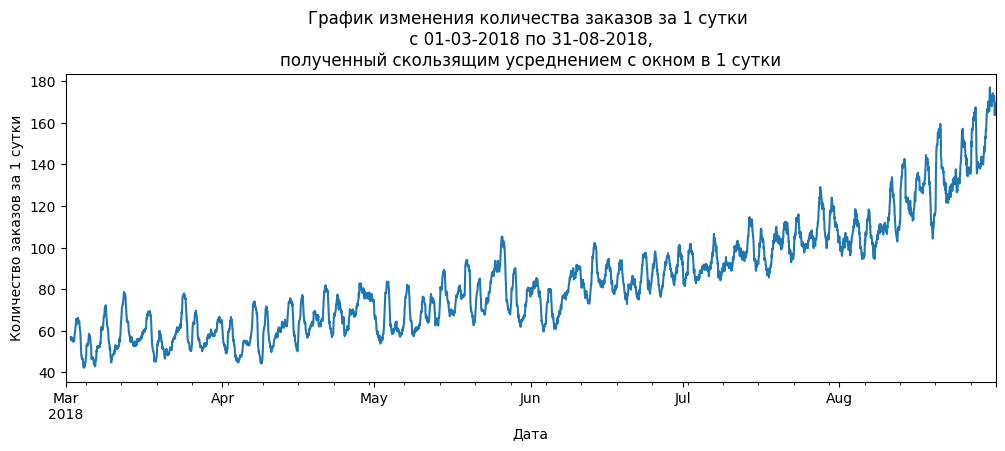

In [37]:
data.num_orders.rolling(24, closed='left').mean().plot(figsize=(12, 4))

plt.ylabel('Количество заказов за 1 сутки')
plt.xlabel('Дата')

start = data.index[0].strftime('%d-%m-%Y')
end = data.index[-1].strftime('%d-%m-%Y')

plt.title(f'График изменения количества заказов за 1 сутки \n c {start} по {end}'
         + ', \nполученный скользящим усреднением с окном в 1 сутки');

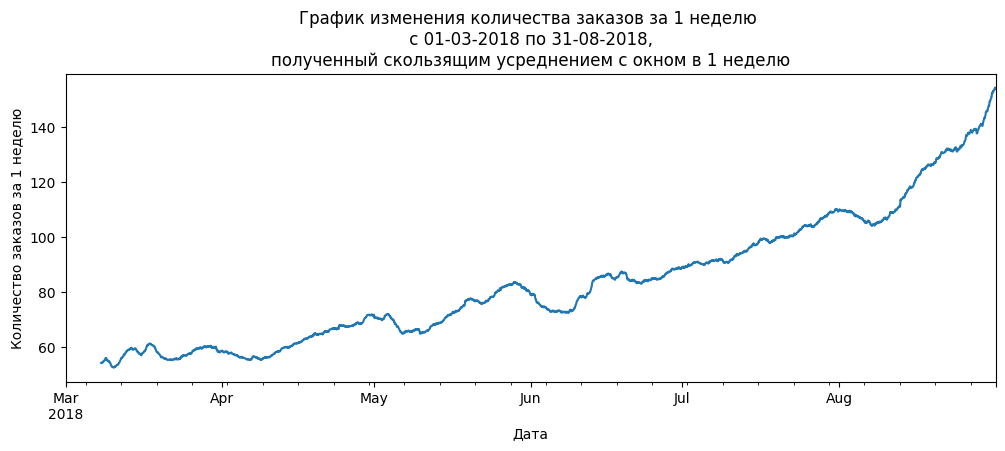

In [38]:
data.num_orders.rolling(168, closed='left').mean().plot(figsize=(12, 4))

plt.ylabel('Количество заказов за 1 неделю')
plt.xlabel('Дата')

start = data.index[0].strftime('%d-%m-%Y')
end = data.index[-1].strftime('%d-%m-%Y')

plt.title(f'График изменения количества заказов за 1 неделю \n c {start} по {end}'
         + ', \nполученный скользящим усреднением с окном в 1 неделю');

Эти графики практически совпадают с графиками тренда при декомпозиции с суточной и недельной периодичностью.

## Обучение

### Создание признаков

Добавим признаки: месяц, день, день недели, час

In [39]:
data['day'] = data.index.day
data['weekday'] = data.index.weekday
data['hour'] = data.index.hour

Так же добавим несколько признаков с отставанием и скользщим средним

In [40]:
max_lag = 168
for i in range(max_lag):
    data['lag_' + str(i + 1)] = data.num_orders.shift(i + 1)

In [41]:
rolling_mean_size = 4
data['rolling_mean_' + str(rolling_mean_size)] = data.num_orders.rolling(rolling_mean_size, closed='left').mean()

In [42]:
data.head(10)

,num_orders,day,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean_4
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Дополнительно добавим признаки о том какая часть дня: утро, полдень, вечер, ночь

### Разбиение данных на выборки

In [43]:
data.shape

(4416, 173)

In [44]:
data.isna().sum().sum()

14200

In [45]:
data.dropna(inplace=True)
feaatures = data.drop(columns='num_orders')
target = data.num_orders

In [46]:
features_train, features_test, target_train, target_test = \
    train_test_split(feaatures, target, shuffle=False, test_size=0.1)

In [47]:
features_train.shape, target_train.shape

((3823, 172), (3823,))

In [48]:
features_test.shape, target_test.shape

((425, 172), (425,))

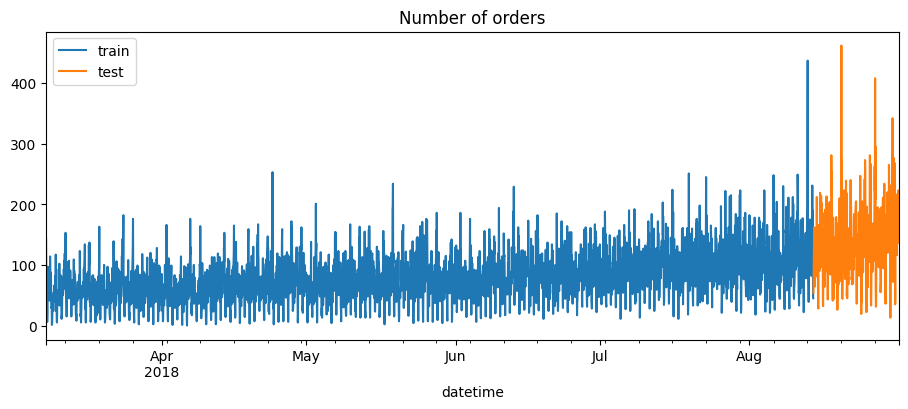

In [49]:
fig, ax = plt.subplots(figsize=(11, 4))
target_train.plot(ax=ax, label='train')
target_test.plot(ax=ax, label='test')
ax.set_title('Number of orders')
ax.legend();

### Обучение моделей

In [50]:
VALID_RMSE = 'RMSE on train'
TEST_RMSE = 'RMSE on test'

report_columns = [VALID_RMSE]

report = pd.DataFrame(columns=report_columns)
report['model'] = []
report.set_index('model', inplace=True)
report

,RMSE on train
model,


In [51]:
def update_report_after_train(model_name, valid_rmse):
    
    report.loc[model_name, VALID_RMSE] = np.float64(valid_rmse).round(2)
    
    print('Результаты обучения модели', model_name)
    display(report.loc[model_name][[VALID_RMSE]])

####  Модель `LinearRegression`

In [52]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(features_train, target_train)

LinearRegression()

In [53]:
predicted_train = lin_reg_model.predict(features_train)
lin_reg_rmse = mean_squared_error(target_train, predicted_train, squared=False)

In [54]:
update_report_after_train(type(lin_reg_model).__name__, lin_reg_rmse)

Результаты обучения модели LinearRegression


RMSE on train    20.94
Name: LinearRegression, dtype: object

#### Модель `Ridge`

In [55]:
def tune(objective, n_trials=10):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    best_score = round(abs(study.best_value), 2)
    best_params = study.best_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    print()
    return best_score, best_params

In [56]:
def ridge_objective(trial):
    params = {}
    params['alpha'] = trial.suggest_float('alpha', 0.001, 5)
    params['random_state'] = RANDOM_STATE

    ridge = Ridge(**params)

    return cross_val_score(
        ridge,
        features_train,
        target_train,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(),
        n_jobs=-1
    ).mean()

In [57]:
%%time
ridge_rmse, ridge_params = tune(ridge_objective, n_trials=100)

Best score: 22.69
Best parameters: {'alpha': 0.0012121672569606985}

CPU times: total: 2.98 s
Wall time: 5.85 s


In [58]:
update_report_after_train(type(Ridge()).__name__, ridge_rmse)

Результаты обучения модели Ridge


RMSE on train    22.69
Name: Ridge, dtype: object

In [59]:
ridge = Ridge(**ridge_params, random_state=RANDOM_STATE)
ridge.fit(features_train, target_train)

Ridge(alpha=0.0012121672569606985, random_state=732568)

#### Модель `Lasso`

In [60]:
def lasso_objective(trial):
    params = {}
    params['alpha'] = trial.suggest_float('alpha', 0.0001, 3)
    params['random_state'] = RANDOM_STATE

    lasso = Lasso(**params)

    return cross_val_score(
        lasso,
        features_train,
        target_train,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(),
        n_jobs=-1
    ).mean()

In [61]:
%%time
lasso_rmse, lasso_params = tune(lasso_objective, n_trials=100)

Best score: 22.25
Best parameters: {'alpha': 2.9998016163977246}

CPU times: total: 4.92 s
Wall time: 12.7 s


In [62]:
update_report_after_train(type(Lasso()).__name__, lasso_rmse)

Результаты обучения модели Lasso


RMSE on train    22.25
Name: Lasso, dtype: object

In [63]:
lasso = Lasso(**lasso_params, random_state=RANDOM_STATE)
lasso.fit(features_train, target_train)

Lasso(alpha=2.9998016163977246, random_state=732568)

#### Модель `DecisionTreeRegressor`

In [64]:
def decision_tree_reg_objective(trial):
    params = {}
    params['max_depth'] = trial.suggest_int('max_depth', 2, 30)
    params['min_samples_split'] = trial.suggest_int('min_samples_split', 30, 60)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 5, 30)

#     params['max_depth'] = 5
#     params['min_samples_split'] = 58
#     params['min_samples_leaf'] = 15
    params['random_state'] = RANDOM_STATE

    model = DecisionTreeRegressor(**params)

    return cross_val_score(
        model,
        features_train,
        target_train,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(),
        n_jobs=-1
    ).mean()

In [65]:
%%time
decision_tree_reg_rmse, decision_tree_reg_params = tune(decision_tree_reg_objective, n_trials=50)

Best score: 26.56
Best parameters: {'max_depth': 5, 'min_samples_split': 49, 'min_samples_leaf': 9}

CPU times: total: 2.33 s
Wall time: 9.18 s


In [66]:
update_report_after_train(type(DecisionTreeRegressor()).__name__, decision_tree_reg_rmse)

Результаты обучения модели DecisionTreeRegressor


RMSE on train    26.56
Name: DecisionTreeRegressor, dtype: object

In [67]:
decision_tree_reg = DecisionTreeRegressor(
    **decision_tree_reg_params,
    random_state=RANDOM_STATE
)
decision_tree_reg.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=9, min_samples_split=49,
                      random_state=732568)

#### Модель `RandomForestRegressor`

In [68]:
def random_forest_reg_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 5, 150)
    params['max_depth'] = trial.suggest_int('max_depth', 7, 20)

#     params['n_estimators'] = 148
#     params['max_depth'] = 18
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1

    model = RandomForestRegressor(**params)

    return cross_val_score(
        model,
        features_train,
        target_train,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(),
        n_jobs=-1
    ).mean()

In [69]:
# %%time
# random_forest_reg_rmse, random_forest_reg_params = tune(random_forest_reg_objective, n_trials=8)
# uncomment for tuning

In [70]:
# comment this cell when tuning
random_forest_reg_rmse = 23.0
# the parameter values were obtained during the tuning

In [71]:
update_report_after_train(type(RandomForestRegressor()).__name__, random_forest_reg_rmse)

Результаты обучения модели RandomForestRegressor


RMSE on train    23.0
Name: RandomForestRegressor, dtype: object

In [72]:
# comment this cell when tuning
random_forest_reg_params = {
    'n_estimators': 115,
    'max_depth': 18
}
# the parameter values were obtained during the tuning

In [73]:
random_forest_reg = RandomForestRegressor(
    **random_forest_reg_params,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
random_forest_reg.fit(features_train, target_train)

RandomForestRegressor(max_depth=18, n_estimators=115, n_jobs=-1,
                      random_state=732568)

#### Модель `CatBoostRegressor`

In [74]:
EARLY_STOPPING_ROUNDS = 50

In [75]:
def catboost_reg_objective(trial):
    params = {}
    params['iterations'] = trial.suggest_int('iterations', 10, 500)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 0.8)
    params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.0)
    
    params['boosting_type'] = 'Plain'
    params['eval_metric'] = 'RMSE'
    params['random_state'] = RANDOM_STATE
    params['logging_level'] = 'Silent'
    
    rmses = []
    for i, (train_index, valid_index) in enumerate(TimeSeriesSplit().split(features_train)):
        
        X_train = features_train.loc[features_train.index[train_index]]
        y_train = target_train.loc[target_train.index[train_index]]
        X_valid = features_train.loc[features_train.index[valid_index]]
        y_valid = target_train.loc[target_train.index[valid_index]]
        
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=EARLY_STOPPING_ROUNDS
        )
        rmses.append(mean_squared_error(target_train, model.predict(features_train), squared=False))
    
    return np.average(rmses)

In [76]:
# %%time
# catboost_study = optuna.create_study()
# catboost_study.optimize(catboost_reg_objective, n_trials=20, n_jobs=-1)
# uncomment for tuning

In [77]:
# uncomment for tuning
# catboost_reg_rmse = round(abs(catboost_study.best_value), 2)
# catboost_reg_params = catboost_study.best_params
# print('Best score:', catboost_reg_rmse)
# print('Best parameters:', catboost_reg_params)

In [78]:
# comment this cell when tuning
catboost_reg_rmse = 22.1
# the parameter values were obtained during the tuning

In [79]:
update_report_after_train(type(CatBoostRegressor()).__name__, catboost_reg_rmse)

Результаты обучения модели CatBoostRegressor


RMSE on train    22.1
Name: CatBoostRegressor, dtype: object

In [80]:
# comment this cell when tuning
catboost_reg_params = {
    'iterations': 385,
    'learning_rate': 0.11365912090843217,
    'l2_leaf_reg': 2.519497211776478
}
# the parameter values were obtained during the tuning

In [81]:
catboost_regressor = CatBoostRegressor(
    **catboost_reg_params,
    random_state=RANDOM_STATE,
    logging_level='Silent'
)

In [82]:
catboost_regressor.fit(
    features_train,
    target_train,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS
)

#### Модель `LGBMRegressor`

In [83]:
def lightgbm_reg_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int("n_estimators", 10, 200)
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    params['max_depth'] = trial.suggest_int("max_depth", 1, 20)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0.01, 10)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.01, 10)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    
    rmses = []
    for i, (train_index, valid_index) in enumerate(TimeSeriesSplit().split(features_train)):
        
        X_train = features_train.loc[features_train.index[train_index]]
        y_train = target_train.loc[target_train.index[train_index]]
        X_valid = features_train.loc[features_train.index[valid_index]]
        y_valid = target_train.loc[target_train.index[valid_index]]
        
        model = LGBMRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            verbose=False
        )
        rmses.append(mean_squared_error(target_train, model.predict(features_train), squared=False))
    
    return np.average(rmses)

In [84]:
# %%time
# study = optuna.create_study()
# study.optimize(lightgbm_reg_objective, n_trials=50, n_jobs=-1)
# uncomment for tuning

In [85]:
# uncomment for tuning
# lightgbm_reg_rmse = round(abs(study.best_value), 2)
# lightgbm_reg_params = study.best_params
# print('Best score:', lightgbm_reg_rmse)
# print('Best parameters:', lightgbm_reg_params)

In [86]:
# comment this cell when tuning
lightgbm_reg_rmse = 18.87
# the parameter values were obtained during the tuning

In [87]:
update_report_after_train(type(LGBMRegressor()).__name__, lightgbm_reg_rmse)

Результаты обучения модели LGBMRegressor


RMSE on train    18.87
Name: LGBMRegressor, dtype: object

In [88]:
# comment this cell when tuning
lightgbm_reg_params = {
    'n_estimators': 147,
    'learning_rate': 0.15145315140804666,
    'max_depth': 18,
    'reg_alpha': 6.311593101180713,
    'reg_lambda': 1.463282121556102
}
# the parameter values were obtained during the tuning

In [89]:
lightgbm_regressor = LGBMRegressor(
    **lightgbm_reg_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [90]:
lightgbm_regressor.fit(
    features_train,
    target_train,
    verbose=False
)

LGBMRegressor(learning_rate=0.15145315140804666, max_depth=18, n_estimators=147,
              random_state=732568, reg_alpha=6.311593101180713,
              reg_lambda=1.463282121556102)

#### Модель `XGBRegressor`

In [91]:
def xgb_reg_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int("n_estimators", 10, 200)
    params['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    params['max_depth'] = trial.suggest_int("max_depth", 1, 30)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0.01, 10)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.01, 10)
    
    params['eval_metric'] = 'rmse'
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['early_stopping_rounds']=EARLY_STOPPING_ROUNDS
    
    rmses = []
    for i, (train_index, valid_index) in enumerate(TimeSeriesSplit(n_splits=3).split(features_train)):
        
        X_train = features_train.loc[features_train.index[train_index]]
        y_train = target_train.loc[target_train.index[train_index]]
        X_valid = features_train.loc[features_train.index[valid_index]]
        y_valid = target_train.loc[target_train.index[valid_index]]
        
        model = XGBRegressor(**params)  
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )
        rmses.append(mean_squared_error(target_train, model.predict(features_train), squared=False))
    
    return np.average(rmses)

In [92]:
# %%time
# study = optuna.create_study()
# study.optimize(xgb_reg_objective, n_trials=100, n_jobs=-1)
# uncomment for tuning

In [93]:
# uncomment for tuning
# xgb_reg_rmse = study.best_value
# xgb_reg_params = study.best_params
# print('Best score:', round(xgb_reg_rmse, 2))
# print('Best parameters:', xgb_reg_params)

In [94]:
# comment this cell when tuning
xgb_reg_rmse = 19.51
# the parameter values were obtained during the tuning

In [95]:
update_report_after_train(type(XGBRegressor()).__name__, xgb_reg_rmse)

Результаты обучения модели XGBRegressor


RMSE on train    19.51
Name: XGBRegressor, dtype: object

In [96]:
# comment this cell when tuning
xgb_reg_params = {
    'n_estimators': 178,
    'learning_rate': 0.05388890810811058,
    'max_depth': 17,
    'reg_alpha': 0.4881085880738958,
    'reg_lambda': 0.38386296624434013
}
# the parameter values were obtained during the tuning

In [97]:
xgb_regressor = XGBRegressor(
    **xgb_reg_params,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [98]:
xgb_regressor.fit(
    features_train,
    target_train,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05388890810811058,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=17, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=178, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=732568, ...)

#### Константная модель

In [99]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [100]:
constant_model_rmse = mean_squared_error(target_test, pred_previous, squared=False)

In [101]:
update_report_after_train('Constant model', constant_model_rmse)

Результаты обучения модели Constant model


RMSE on train    58.82
Name: Constant model, dtype: object

### Выбор лучшей модели

In [102]:
report

,RMSE on train
model,
LinearRegression,20.94
Ridge,22.69
Lasso,22.25
DecisionTreeRegressor,26.56
RandomForestRegressor,23.0
CatBoostRegressor,22.1
LGBMRegressor,18.87
XGBRegressor,19.51
Constant model,58.82


 - По результатам обучения лучшей стала модель `LGBMRegressor`
 - Все модели, кроме константной прошли критерий качества `RMSE < 48` при обучении 

Протестируем её

## Тестирование

In [103]:
predicted_test = lightgbm_regressor.predict(features_test)
test_rmse = mean_squared_error(target_test, predicted_test, squared=False)
print(f'RMSE лучшей модели на тесте:  {test_rmse:.2f}')

RMSE лучшей модели на тесте:  37.30


Модель прошла критерий качества при тестировании, то есть не привыcила значение `RMSE = 48`

## Общий вывод

 1. 
 - Начальные данные с точностью до 10 минут для исследования были ресемплированны по одному часу;
 - В процессе анализа данных при декомпозиции обнаружено:
    - присутствие тренда с разной периодичностью (суточной, недельной, месячной):
       - в апреле тренд в среднем не изменяется, или не наблюдается;
       - с начала апреля до начала августа наблюдается "относительно равномерное" увеличение заказов. Если анализировать график с недельной периодичностью, то в этот период увеличения наблюдаются локальные небольшие спады в конце апреля - начале мая, в конце мая - начале июня, в конце июля - начале августа, при этом спада в конце июня - начале июля не наблюдается;
       - в течение августа скорость увеличение заказов от начала месяца к концу увеличивается по сравнению с предыдущим периодом увеличения с апреля по август, при этом скорость неравномерная - к концу месяца наблюдается ускорение увеличения заказов. Можно предположить, что это связано с тем, что август является месяцем с максимальным количеством туристов (или отпусков).
    - присутствие сезонности с разной периодичностью (суточная, недельная):
        - наблюдается суточная периодичность:
            - с минимум в 6 утра;
            - с максимумом в 12 ночи;
            - с локальными максимумами в течение дня в 10 и 16 часов;
        - также наблюдается недельная периодичность:
            - с минимальным значением в 6 часов утра в четверг каждой недели;
            - с максимальными значениями в 12 часов ночи в ночь с пятницы на субботу и в ночь с воскресенья на понедельник.
 
 2. 
  - Для исследования были добавлены следующие признаки:
        - день, день недели, час;
        - несколько признаков с отставанием (до 168 часов) и признак со скользщим средним с окном в 4 часа;
 3. 
  - Для обучения были использованны:
        - линейные модели: `LinearRegression`, `Ridge`, `Lasso`;
        - модели на основе деревьев: `DecisionTreeRegressor`, `RandomForestRegressor`;
        - модели на основе градиентного бустинга: `CatBoostRegressor`, `LGBMRegressor`, `XGBRegressor`
  - Лучшее качество при обучении показала модель `LGBMRegressor`.
     - на тесте качество модели не привыcило порог `RMSE = 48`